In [ ]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

In [ ]:
import os
os.kill(os.getpid(), 9)

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    b = [i*2-1 for i in b] # transformer les 0 en -1 et sans modifier les 1.
    val = 0
    for i,j in edges:
      val += b[i]*b[j]
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, -1, -1, 1, 1]


#### visualization of the graph

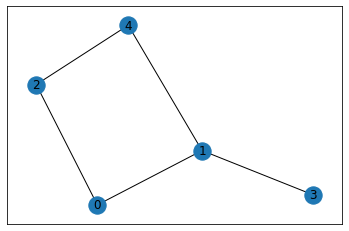

In [ ]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

Puisque $e^{-i\beta H_c} = U_{ZZ}(2\beta)$,
$$e^{-i\beta H_c} = e^{-\beta \sum_{i,j \in E} \sigma_i \sigma_j} = \prod_{i,j \in E} e^{-i\beta \sigma_i \sigma_j}$$
Sachant que $\langle 1 |\sigma |1 \rangle = 1$ et $\langle 0 |\sigma |0 \rangle = - 1$  on obtient,


$$\langle x_i x_j |e^{-i\beta \sigma_i \sigma_j} |x_i x_j \rangle= e^{-i\beta}\text{,    si } x_i=x_j$$
$$\langle x_i x_j |e^{-i\beta \sigma_i \sigma_j} |x_i x_j \rangle= e^{+i\beta} \text{,    si } x_i=-x_j$$

In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for i in range(n_qubits):
      layer.apply(RX(theta), i)

    for i,j in edges:
      layer.apply(U_ZZ(2*beta), i, j)
    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for i in range(n_qubits): #initialization
      prog.apply(H, qubits[i])

    for i in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*i], parameters[2*i+1]), qubits)
        
    # END TODO
    circ = prog.to_circ()

    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
      b = [int(i)*2-1 for i in sample.state.bitstring] # transforme les 0 en -1 sans modifier les 1.
      for i,j in edges:
        obs += b[i]*b[j]*sample.probability
    # END TODO
    return obs


In [ ]:
import numpy as np
np.random.random(3)

array([0.24710518, 0.50033595, 0.02287886])

In [ ]:
from scipy.optimize import minimize

### Random initialisation

### Question 5: 
réponse à la question:

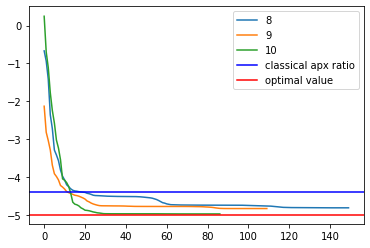

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk, nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend();

à partir de 10 couches l'algorithme converge vers la solution optimale.  

### Question 6: smart initialization

En utilisant l'hypothèse selon laquelle $e^{A+B} \approx e^A e^B$, il est possible de réécrire $|\psi_{final}\rangle$:

$$|\psi_{final}\rangle = e^{-i\int_0^T H(s) \text{d} s} |\psi_0\rangle \approx \prod_{k=1}^p e^{-i(1-\frac k p) \sigma_x^{~k} \frac T p} e^{-i\frac{kT}{p^2} H_C}|\psi_0\rangle$$

On peut alors identifier $\beta_k$ et $\theta_k$: 

$e^{-i\beta_k H_C} = e^{-i\frac{kT}{p^2}H_C}$ et $RX(\theta_k) = e^{-i\frac{\theta_k} 2 X} = e^{-i(1-\frac k p) \sigma_x^{~k} \frac T p}$

On en déduit:
$$\beta_k = \frac{kT}{p^2} \text{, et }\theta_k = (1-\frac k p)\frac {2T} p$$

In [14]:
import matplotlib.pyplot as plt

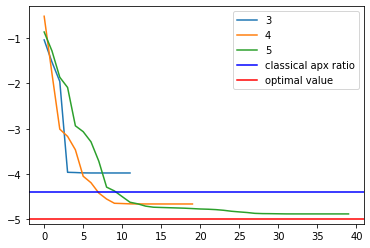

In [18]:
T = 1

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []

    for k in range(1,nlayers+1):
      theta_k = (1-k/nlayers)*2*T/nlayers
      beta_k = k*T/nlayers
      parameters_init.append(theta_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend();

Une meilleur innitialisation des paramètres permet de restreindre le nombre de layers nécéssaires à la convergence de l'algorithme. En effet, ici seulement 4 couches permettent d'obtenir un résultat satisfaisant. 

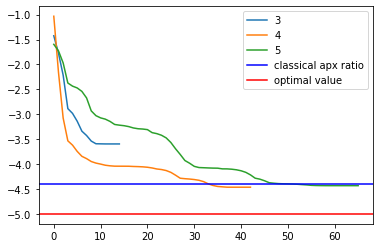

In [19]:
T = 100

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []

    for k in range(1,nlayers+1):
      theta_k = (1-k/nlayers)*2*T/nlayers
      beta_k = k*T/nlayers
      parameters_init.append(theta_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend();

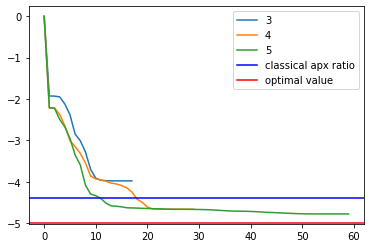

In [20]:
T = 0.01

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []

    for k in range(1,nlayers+1):
      theta_k = (1-k/nlayers)*2*T/nlayers
      beta_k = k*T/nlayers
      parameters_init.append(theta_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend();

Choisir un $T>1$ (ici $T=100$) semble dégradé la qualité de l'algorithme, il converge plus lentement et vers un résultat moins pertinant.
Choisir un $T<1$ (ici $T=0.01$) ne semble pas avoir de conséquences particuliètement positive sur la vitesse de l'algorithme ou la qualité de la solution.